In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import rasterio
from rasterio.plot import plotting_extent, show, show_hist, reshape_as_image
from rasterio.mask import mask
import os

from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import torch
from terrafm import terrafm_base

In [2]:
def convert_to_reflectance(band):
    """
    Convert a band from digitized to reflectance. 
    Works for bands 1-7 only.
    """
    mult_parameter = 2.75e-05
    add_parameter = -0.2
    return band * mult_parameter + add_parameter

In [3]:
def preprocess_data(folder_name : str, area_of_interest : geopandas.GeoDataFrame, bands = [1, 2, 3, 4]):

    """ 
    Read in and preprocess raster data from a specified folder path.

    Parameters:
    folder_path (str): Path to the folder containing raster band files.
    area_of_interest (geopandas.GeoDataFrame): GeoDataFrame defining the area to crop the raster data.
    create_new (bool): Whether to create a new combined raster file. Defaults to True.
    new_file_name (str): Name for the new combined raster file. Required if create_new is True.
    bands (list): List of band numbers to process. Defaults to [1, 2, 3, 4].

    Returns:
    rasterio.DatasetReader: The combined raster data after preprocessing.
    """
    
    file_destination = "data/combined_rasters"
    band_number_str = str(len(bands))
    folder_path = os.path.join("data/", folder_name)
    new_file_name = f"{folder_name}_{band_number_str}_bands_processed.tif"
    new_file_path = os.path.join(file_destination, new_file_name)
    does_file_exist = os.path.exists(new_file_path)
    
    if not does_file_exist:

        band_data_combined = []
        for band in bands:
            band_substring = f"_B{band}"
            # find band file in folder
            band_file = [f for f in os.listdir(folder_path) if band_substring in f][0]
            band_path = os.path.join(folder_path, band_file)
            # read in band file
            with rasterio.open(band_path) as band_data:

                area_of_interest = area_of_interest.to_crs(band_data.crs)
                
                cropped_band_data, transform = mask(band_data, area_of_interest.geometry, crop=True)
                cropped_reflectance_band_data = convert_to_reflectance(cropped_band_data)
                band_data_combined.append(cropped_reflectance_band_data)

                meta = band_data.meta.copy()
                meta.update(
                    {                    
                        "transform": transform,
                        "height":cropped_reflectance_band_data.shape[1],
                        "width":cropped_reflectance_band_data.shape[2],
                        "count":len(bands),
                        "dtype": cropped_reflectance_band_data.dtype
                    }
                )

            print(f"Band {band} done")

        combined_bands_final = np.vstack(band_data_combined)

        with rasterio.open(new_file_path, "w", **meta) as dest:
            dest.write(combined_bands_final)

        combined_bands_final = rasterio.open(new_file_path)

    else:
        
        combined_bands_final = rasterio.open(new_file_path)

    return combined_bands_final

In [ ]:
# conversion from 7 bands to 12 to be read into terrafm model

def landsat5_to_terrafm_channels(x):
    """
    x: (H, W, 7) Landsat 5 TM array (scaled)
       Band order: [B1, B2, B3, B4, B5, B6(thermal), B7]

    returns: (H, W, 12) TerraFM-compatible array
    """
    H, W, _ = x.shape
    out = np.zeros((H, W, 12), dtype=x.dtype)

    # Sentinel-2-like mapping
    out[..., 1]  = x[..., 0]  # Blue  (L5 B1)
    out[..., 2]  = x[..., 1]  # Green (L5 B2)
    out[..., 3]  = x[..., 2]  # Red   (L5 B3)
    out[..., 7]  = x[..., 3]  # NIR   (L5 B4)
    out[..., 10] = x[..., 4]  # SWIR1 (L5 B5)
    out[..., 11] = x[..., 6]  # SWIR2 (L5 B7)
    out[..., 8] = x[..., 3] 

    # All others remain zero:
    # coastal, red-edge, water vapor

    return out

## ML Classification Inputs

In [5]:
file_for_analysis = "pre_tsunami" # these names must match folder names (max 3)

geojson_area_of_interest = geopandas.read_file("data/east_coast_map.geojson") # set to path for geojson file for area of analysis focus 

bands_of_interest = [1, 2, 3, 4]  # which bands are you interested in

bands_for_classification = [1, 2, 3, 4, 5, 6, 7]  # which bands to use for classification

k_clusters = 6  # number of clusters for KMeans

c:\Users\foxy_\anaconda3\envs\qcr_env\Lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


In [6]:
# read in pre-processed data

raster = preprocess_data(folder_name = file_for_analysis, area_of_interest = geojson_area_of_interest, bands = bands_for_classification)

In [7]:
# reshaping files to work with model

x = np.moveaxis(raster.read(), 0, -1)
print(x.shape)
height = x.shape[0]
width = x.shape[1]
band_number = x.shape[2]

(921, 1135, 7)


In [8]:
# normalizing data and reformatting

x_data = x.reshape(-1, band_number)
scaler = StandardScaler().fit(x_data)
x_scaled = scaler.transform(x_data).astype(np.float32)

x_scaled_img = x_scaled.reshape(height, width, band_number)
x_scaled_img = landsat5_to_terrafm_channels(x_scaled_img)

In [ ]:
# converting to patches to align with terrafm model input

PATCH = 224

pad_h = (PATCH - height % PATCH) % PATCH
pad_w = (PATCH - width % PATCH) % PATCH

x_scaled_img_pad = np.pad(
    x_scaled_img,
    ((0, pad_h), (0, pad_w), (0, 0)),
    mode="reflect"
)

H2, W2, _ = x_scaled_img_pad.shape
print("Padded shape:", x_scaled_img_pad.shape)

patches = []
coords = []

for y in range(0, H2, PATCH):
    for x in range(0, W2, PATCH):
        patch = x_scaled_img_pad[y:y+PATCH, x:x+PATCH, :]
        patches.append(patch)
        coords.append((y, x))

patches = np.stack(patches)   # (N, 224, 224, B)
print("Total patches:", patches.shape[0])

patches_torch = torch.tensor(
    patches,
    dtype=torch.float32
).permute(0, 3, 1, 2)

Padded shape: (1120, 1344, 12)
Total patches: 30


In [ ]:
# loading in terrafm model

device = 'cpu'
model = terrafm_base()
state = torch.load("TerraFM-B.pth", map_location=device)
model.load_state_dict(state, strict=False)
model.to(device)
model.eval()

print("Loaded TerraFM on device:", device)

Loaded TerraFM on device: cpu


In [ ]:
# generating embeddings to split into batches

embeddings = []
batch_size = 8

with torch.no_grad():
    for i in range(0, len(patches_torch), batch_size):
        batch = patches_torch[i:i+batch_size].to(device)
        emb = model(batch)             
        embeddings.append(emb.cpu().numpy())

embeddings = np.concatenate(embeddings, axis=0)
print("Embeddings shape:", embeddings.shape)

Embeddings shape: (30, 768)


In [ ]:
# kmeans clustering

kmeans = KMeans(n_clusters=k_clusters, n_init=20, random_state=2)
labels = kmeans.fit_predict(embeddings)

C:\Users\foxy_\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\foxy_\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\foxy_\anaconda3\envs\qcr_env\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\foxy_\anaconda3\envs\qcr_env\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\foxy_\anaconda3\envs\qcr_env\Lib\subproce

In [ ]:
# generate classification map

class_map = np.zeros((H2, W2), dtype=np.uint8)

for (y, x), label in zip(coords, labels):
    class_map[y:y+PATCH, x:x+PATCH] = label

class_map = class_map[:height, :width]

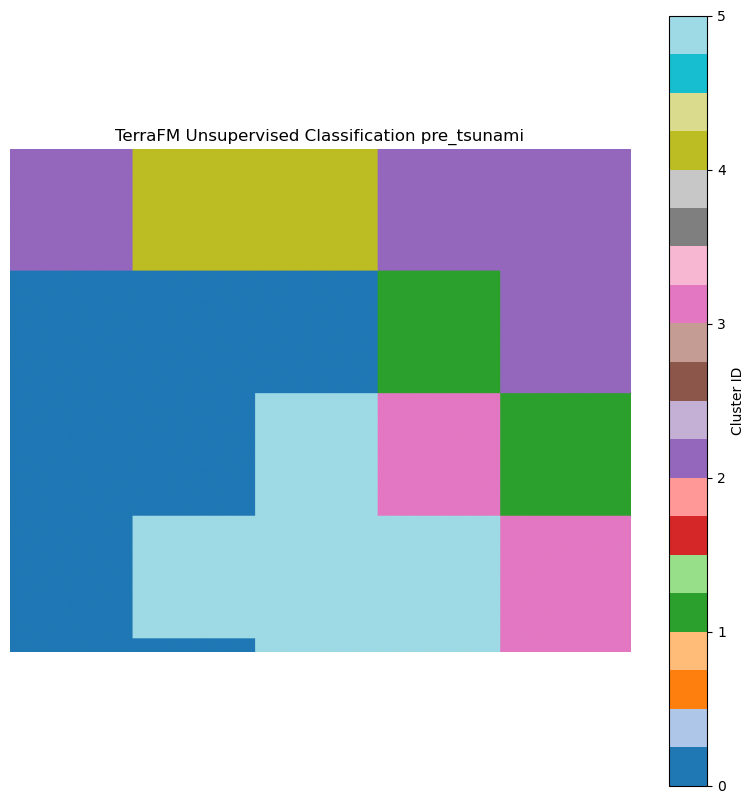

In [ ]:
# plot map

plt.figure(figsize=(10, 10))
plt.imshow(class_map, cmap="tab20")
plt.title(f"TerraFM Unsupervised Classification {file_for_analysis}")
plt.colorbar(label="Cluster ID")
plt.axis("off")
plt.show()